In [3]:
import numpy as np 
import celerite
from celerite import terms
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import rcParams 
from astroML.plotting.mcmc import convert_to_stdev
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

In this notebook we explore the properties of the log-likelihood that is employed in finding the MLE estimates of DRW parameters for Gaussian Process parametrization of Quasar Light curve variability. 

## Table of Contents: <a id='toc'></a>

  * [Section 1 : simulate the DRW light curve ](#simulate_lc)
  * [Section : Gaussian Noise with Celerite](#gaussian_noise)
  * [Section : plot logL residuals of flat vs other priors](#flat_residuals)
  * [Section : Gaussian test ](#gauss_test)
  * [Section : plot logL in four different views... ](#logL_views)
  * [Section: Direction perpendicular : K and sigma hat](#sigmahat_K)

In [4]:
# Make a directory for today :
# Make a todays dir to save the figure ...
import os 
import datetime

outDir = os.path.join(os.getcwd()[:-len('code')],'data_products/Fig_Celerite_simulated_LC',
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
print('We will save this figure in  %s'%outDir)



We will save this figure in  /Users/chris/GradResearch/DRW_Celerite/data_products/Fig_Celerite_simulated_LC/2017-11-09/


## Simulate the DRW light curve <a id='simulate_lc'><a/>

[Jump to top](#toc)

In [2]:
def sim_DRW_lightcurve(t,SFinf,tau,mean_mag):
    '''Simulate a DRW lightcurve for a given time series t, with parameters
       (SFinf, tau), and mean magnitude.
       Uses equations A4 and A5 in Kelly 2009 (see also MacLeod+10 sec 2.2).'''
    mu = mean_mag  # the input parameter : mean mag: make an alias 
    mag = np.zeros(len(t),dtype=np.float32) # initialize an array of empty values
    mag[0] = mean_mag # start from the mean magnitude 
    dt = np.diff(t) # an array of differences  t[i+1]-t[i]
    for i in range(1,len(t)):
        # calculate the mean 
        loc = np.exp(-dt[i-1]/tau)*mag[i-1] + mu*(1-np.exp(-dt[i-1]/tau))
        # calculate the variance 
        var = 0.5 * SFinf**2 * (1-np.exp(-2*dt[i-1]/tau))
        # draw the magnitude value from a Gaussian distribution
        # with a given mean and standard deviation ( = sqrt(variance))
        mag[i] = np.random.normal(loc=loc,scale=np.sqrt(var))
    return mag

def sampling(tau_in = 100, length=10, t_min=1, dt = 10 , 
                        regular=False, verbose=False):
    ''' A convenience function to return user-defined sampling 
    
    Input: 
    -------
    tau_in : input timescale (default: 100 days )
    length : length in terms of multiples of timescale (default: 10) 
    t_min : starting point of lightcurve (default : 1 )
    dt : interval between samplings, if regular = True, then 
        this is the exact interval,  otherwise we divide the 
        light curve length by dt to determine the number 
        of points 
    regular : boolean (True / False). Use regular sampling with dt, 
        or random sampling with Npts = floor(total_timespan / dt) ? 
        
    Returns:
    ---------
    t : sampling times 
    '''
    t_max = t_min + length*tau_in
    if regular : 
        # evenly spaced sampling within the chosen interval 
        if verbose: 
            print('Using regular sampling')
        t = np.arange(t_min, t_max, dt)
    else :
        # random sampling with the chosen number of points ... 
        # The input coordinates must be sorted
        if verbose: 
            print('Using random sampling')
        Npts= int(np.floor((t_max - t_min) / dt))
        t = np.sort(np.random.uniform(t_min, t_max, Npts)) 
        
    return t


[(-9.2103403719761818, 0.0), (-9.2103403719761818, 0.0)]


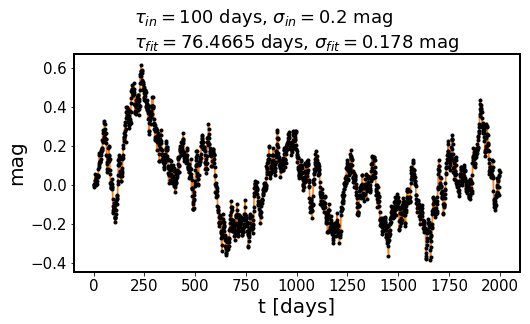

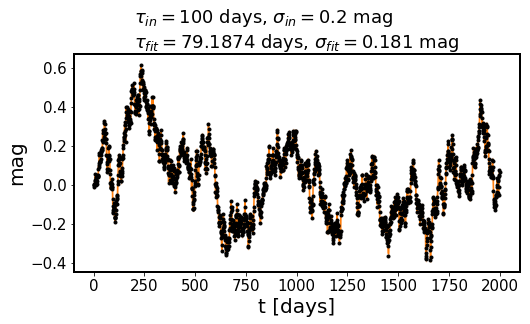

In [31]:
%matplotlib inline

# Simulate a DRW lightcurve and fit with celerite 
tau_in = 100
sigma_in = 0.2
SF_inf = sigma_in * np.sqrt(2)
yerr =  0.001 
#  length = 20 tau,  delta_time = 1 day 
t = sampling(tau_in = tau_in, length=20, regular=True, dt=1)
# we add the Gaussian noise with st.dev = yerr 
noise = np.random.normal(loc=0.0, scale=yerr, size=len(t))
y = sim_DRW_lightcurve(t, SF_inf, tau_in , 0) + noise 
    
# fitting procedure : 

# initialize the kernel ... 
log_a_in = 2 * np.log(sigma_in)
log_c_in = np.log(1/tau_in)
kernel = terms.RealTerm(log_a = log_a_in , log_c = log_c_in)

# call the model 
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)

# optimization of the results 

sigma_bounds = [0.01, 1.0]
tau_bounds = [1,10000]
logc_bounds= (np.log(1/max(tau_bounds)), np.log(1/min(tau_bounds)) )
loga_bounds = (2*np.log(min(sigma_bounds)), 2*np.log(max(sigma_bounds)))
bounds = [loga_bounds, logc_bounds]
#bounds = gp.get_parameter_bounds()
print(bounds)

initial_params = gp.get_parameter_vector()

for prior in ['Jeff1', 'flat'] : 
    if prior is 'Jeff1' : # (1/sigma) * (1/tau) 
        def neg_log_like(params,y,gp):
            gp.set_parameter_vector(params)
            log_a = params[0]
            log_c = params[1]
            return -gp.log_likelihood(y) + (log_a / 2.0) - log_c    
    if prior is 'flat' : 
        def neg_log_like(params, y, gp):
            gp.set_parameter_vector(params)
            return -gp.log_likelihood(y)

    r = minimize(neg_log_like, initial_params, 
                 method="L-BFGS-B", bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(r.x)

    res = gp.get_parameter_dict()
    sigma_fit = np.exp(res['kernel:log_a']/2)
    tau_fit = 1.0 / np.exp(res['kernel:log_c'])

    # plot the prediction
    x = np.linspace(min(t),max(t) , 5000)
    pred_mean, pred_var = gp.predict(y, x, return_var=True)
    pred_std = np.sqrt(pred_var)

    color = "#ff7f0e"
    fig,ax = plt.subplots(1,1,figsize=(8,4))
    ax.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
    ax.plot(x, pred_mean, color=color)
    ax.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                     edgecolor="none")
    ax.set_xlabel('t [days]')
    ax.set_ylabel('mag')

    title = r'$\tau_{in}=$'+str(tau_in)+' days, ' +\
    r'$\sigma_{in}=$'+str(sigma_in)+' mag'+'\n'\
           +r'$\tau_{fit}=$'+str(tau_fit)[:7]+' days, '+\
        r'$\sigma_{fit}=$'+str(sigma_fit)[:5]+' mag'

    ax.set_title(title,multialignment='left')
    plt.savefig(outDir+'sim_lc_'+prior+'_prior_fit.png', bbox_inches='tight')

sim_lc = {'y':y, 't':t}
np.save( outDir+'sim_lc_y_t', sim_lc)

## Read-in the light curve from a file .. <a id='read_from_file'></a>

[Jump to top](#toc)

In [329]:
from astropy.table import Table
# Read in one of the light curves that we fit ....
DirIn = '../raw_data/DRWtestCeleriteZI/'
files = os.listdir(DirIn)
i=0
lc = Table.read(DirIn +files[i], format='ascii', names=['time', 'mag', 'err'] )    
t,y,yerr = lc['time'], lc['mag'], lc['err']

In [330]:
#Use exactly that light curve as above to make the figuere ... 
#sim_lc = np.load(outDir + 'sim_lc_y_t.npy').item()
#y = sim_lc['y']
#t = sim_lc['t']

# initialize the kernel ... 
sigma_in = 0.2
tau_in =  100
kernel = terms.RealTerm(log_a = 2 * np.log(sigma_in), 
                        log_c = np.log(1/tau_in))

# call the model 
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)

# Evaluate the log-likelihood manually on a grid of two parameters...
N = 100
# span the grid : truth is tau=100, sigma=0.2
tau_grid = np.linspace(10,300,N)
sigma_grid = np.linspace(0.1, 0.4, N)
# re-express it as logs since that's what goes into fitting 
log_a_grid = 2 * np.log(sigma_grid)
log_c_grid = np.log(1/tau_grid)

# initialize as empty array

loglike_dic = {}
for prior in ['Jeff1','flat','p1', 'p2', 'Jeff2']: # ,  
    print('Calculating the negloglike grid for %s prior'%prior)
    loglike = np.zeros([N,N], dtype=float)
    for i in range(len(log_a_grid)):
        for j in range(len(log_c_grid)):
            params = [log_a_grid[i],log_c_grid[j]]
            if prior is 'p1' : # sigma*tau
                def neg_log_like(params,y,gp):
                    gp.set_parameter_vector(params)
                    log_a = params[0]
                    log_c = params[1]
                    return -gp.log_likelihood(y) - (log_a / 2.0) + log_c

            if prior is 'p2' : # sigma_hat * tau 
                def neg_log_like(params, y, gp):
                    gp.set_parameter_vector(params)
                    log_a = params[0]
                    log_c = params[1]
                    return -gp.log_likelihood(y)  +0.5* (-np.log(2) + log_c - log_a  )

            if prior is 'Jeff1' : # (1/sigma) * (1/tau) 
                def neg_log_like(params,y,gp):
                    gp.set_parameter_vector(params)
                    log_a = params[0]
                    log_c = params[1]
                    #print(log_a/2.0,log_c, log_a/2.0 - log_c)
                    #print(-gp.log_likelihood(y))
                    return -gp.log_likelihood(y) + (log_a / 2.0) - log_c

            if prior is 'Jeff2' : # (1/sigma_hat) * (1/tau) 
                def neg_log_like(params, y, gp):
                    gp.set_parameter_vector(params)
                    log_a = params[0]
                    log_c = params[1]
                    return -gp.log_likelihood(y)  +0.5* (np.log(2) - log_c + log_a  )

            if prior is 'flat' : # flat prior 
                def neg_log_like(params, y, gp):
                    gp.set_parameter_vector(params)
                    return -gp.log_likelihood(y)

            loglike[i,j] = neg_log_like(params,y,gp)
    # store this grid of logike ... 
    loglike_dic[prior] = loglike

print('Done')

Calculating the negloglike grid for Jeff1 prior
Calculating the negloglike grid for flat prior
Calculating the negloglike grid for p1 prior
Calculating the negloglike grid for p2 prior
Calculating the negloglike grid for Jeff2 prior
Done


### Illustrate results of Celerite fitting with MLE errors <a id='various_priors'></a>

[Jump to top](#toc)

In [11]:
# Read in the results of Celerite fitting 
# the DRW with the saved light curves .... 

fname = 'ZI_fits_results_11-07-17.npy'
simDir = '../data_products/Fig_Celerite_ZI_LC_fits/2017-11-08/'
results = np.load(simDir+fname).item()


In [334]:
results[prior].keys()

dict_keys(['sigma_fit', 'tau_fit', 's_sigma', 's_tau', 's_loga', 's_logc'])

flat 42.8039722737 0.0375954887851 124.951418714 0.223941699481
p1 27.7010264191 0.0294296838357 84.0872544195 0.183910513925
p2 52.8863987994 0.0453735242561 131.630537711 0.230221846541
Jeff1 18.0007851462 0.0215084633406 70.9143649826 0.175832449193
Jeff2 17.2107925243 0.0201173311931 69.2620899618 0.16761029716


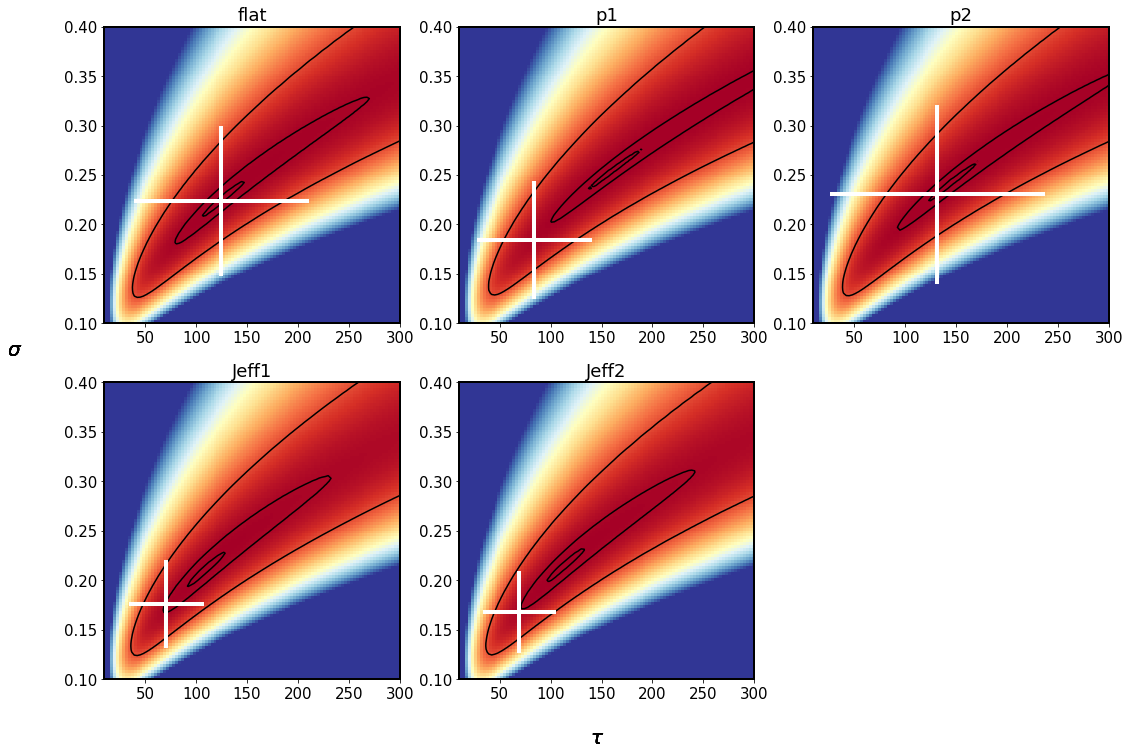

In [337]:
%matplotlib inline
# Plot the posterior pdf based on each prior... 

from matplotlib import ticker
fig,axs = plt.subplots(2,3, figsize=(18,12))
ax = np.ravel(axs)
i =0 
for prior in ['flat', 'p1', 'p2', 'Jeff1', 'Jeff2']:
    #z = loglike_dic[prior] / 500
    
    # attempt to normalize....
    x = loglike_dic[prior]
    shift = x-min(np.ravel(x))
    norm = np.sum(shift)
    z = shift / norm
    # so that now np.sum(new) ~ 1 
    sigma_tau_grid = True
    if sigma_tau_grid : 
        im = ax[i].imshow(z, extent=(tau_grid[0], tau_grid[-1],
                                     sigma_grid[0], sigma_grid[-1]),
                      cmap=plt.cm.get_cmap('RdYlBu'),vmax=0.0001,
                       aspect='auto', origin='lower')
        # plot the error ,....
        dx = results[prior]['s_tau'][i]
        dy = results[prior]['s_sigma'][i]
        x0 = results[prior]['tau_fit'][i]
        y0 = results[prior]['sigma_fit'][i]
        print(prior,dx,dy,x0,y0)
        ax[i].plot([x0,x0],[y0-1.96*dy,y0+1.96*dy], lw=4, c='white')
        ax[i].plot([x0-1.96*dx,x0+1.96*dx],[y0,y0], lw=4, c='white')
    
        ax[i].contour(tau_grid, sigma_grid, convert_to_stdev(z),
           levels=(0.683, 0.955, 0.997), colors='k')
        
        fig.text(0.5,0.05, r'$\tau$', fontsize=20)
        fig.text(0.05,0.5, r'$\sigma$',fontsize=20)
    else: # ue the log_a, log_c  grid .... 
        im = ax[i].imshow(z, extent=(log_c_grid[0], log_c_grid[-1],
                                     log_a_grid[0], log_a_grid[-1]),
                      cmap=plt.cm.get_cmap('RdYlBu'),vmax=0.0001,
                       aspect='auto', origin='lower')
        # plot the error ....
        dy = results[prior]['s_loga'][i]
        dx = results[prior]['s_logc'][i]
        sigma_0, tau_0 = 0.23, 100
        log_a0, log_c0 = 2 * np.log(sigma_0), np.log(1/tau_0)
        ax[i].plot([log_c0,log_c0],[log_a0,log_a0+1.96*dy], lw=4, c='white')
        ax[i].plot([log_c0,log_c0+1.96*dx],[log_a0,log_a0], lw=4, c='white')
        
        # plot the contours... 
        ax[i].contour(log_c_grid, log_a_grid, convert_to_stdev(z),
           levels=(0.683, 0.955, 0.997), colors='k') 
        fig.text(0.5,0.05, r'$\log{(1/\tau))}$', fontsize=20)
        fig.text(0.05,0.5, r'$\log{(\sigma^{2})}$',fontsize=20, rotation=90)
        
    ax[i].set_title(prior)
    i += 1
ax[i].axis('off')
#cax = fig.add_axes([0.57,0.2,0.29,0.02])
#cbar = plt.colorbar(im,cax, orientation='horizontal')
#cbar.set_label(label=r'$log(L)$', color='white')

plt.savefig(outDir+'posterior_pdf_all_priors.png', bbox_inches='tight')


### Simulate draws from a Gaussian distribution,  and try to recover the input parameters using log-likelihood method .... <a id='gauss_test'></a>

[Jump to toc](#toc)

In [308]:
# Calculate by-hand Gaussian log-likelihood on a  similar grid... 
# sample : drawn from a normal distribution
# with mu=0, and sigma = 1 ... 

# simulate the draws from  a normal distribution ... 
N_pts = 400
y = np.random.normal(loc=0, scale = 1, size=N_pts)



the MLE are : [ 0.98251503 -0.09331152]
the Standard Error on MLEs : [ 0.03473721  0.04912575]


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numdifftools/extrapolation.py:443: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numdifftools/limits.py:150: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numdifftools/limits.py:151: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numdifftools/limits.py:152: RuntimeWarning: invalid value encountered in less
  ((der < p25-1.5*iqr) + (p75+1.5*iqr < der)))


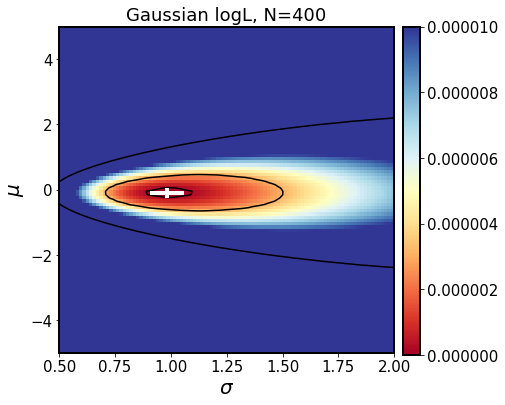

In [317]:

# define the Gaussian log-likelihood ... 
def gauss_negloglike(params,y) : 
    sigma = params[0]
    mu = params[1]
    n = len(y)
    logL = -n*np.log(sigma) - (n/2.0)*np.log(2*np.pi) -\
       (1/(2.0*sigma*sigma))*np.sum((y-mu)*(y-mu))
    return -logL


# Manually evaluate the Gaussian log-likelihood on 
# a grid 
mu_max = 5
N=100
mu_grid = np.linspace(-mu_max,mu_max,N)
sigma_grid = np.linspace(0.5,2, N)

loglike_gauss = np.zeros([N,N], dtype=float)
for i in range(len(mu_grid)):
    for j in range(len(sigma_grid)):
        mu = mu_grid[i]
        sig = sigma_grid[j]
        loglike_gauss[i,j] = gauss_negloglike([sig,mu],y)

# find the minimum of this Gaussian log-likelihood 
# Using scipy optimize minimize...
sigma_bounds = [0.001, 10.0]
mu_bounds = [-1000,1000]
bounds = [sigma_bounds, mu_bounds]
initial_params = [0.1, 1]
r = minimize(gauss_negloglike, initial_params, 
             method="L-BFGS-B", bounds=bounds, args=(y))
print('the MLE are :',r['x'])

# Calculate error on the estimate of sigma, mu, 
# given our input data ...

import numdifftools as nd
def Wrap_neg_log_like(theta) : 
    return gauss_negloglike(theta, y)

Hfun = nd.Hessian(Wrap_neg_log_like, full_output=True)
hessian_ndt, info = Hfun(r['x'])

# standard deviation is the square of variance
se = np.sqrt(np.diag(np.linalg.inv(hessian_ndt)))

# error from hessian on log_a, log_c
s_sigma = se[0]
s_mu = se[1]

print('the Standard Error on MLEs :',se)

# plot the Gaussian likelihood... I wonder what it looks like ! 

%matplotlib inline
from matplotlib import ticker

fig,ax = plt.subplots(1,1,figsize=(6,6))
# attempt to normalize....
x = loglike_gauss
shift = x-min(np.ravel(x))
norm = np.sum(shift)
z = shift / norm
# so that now np.sum(new) ~ 1 

im = ax.imshow(z, extent=(sigma_grid[0], sigma_grid[-1],
                          mu_grid[0], mu_grid[-1]),
              cmap=plt.cm.get_cmap('RdYlBu'), vmax=0.00001,
               aspect='auto', origin='lower')
# plot the error ,....
sigma_hat = r['x'][0]
mu_hat = r['x'][1]


ax.plot([sigma_hat,sigma_hat],
        [mu_hat-1.96*s_mu,mu_hat+1.96*s_mu], 
        lw=4, c='white')

ax.plot([sigma_hat-1.96*s_sigma,sigma_hat+1.96*s_sigma],
        [mu_hat,mu_hat], 
        lw=4, c='white')

ax.contour(sigma_grid, mu_grid, convert_to_stdev(z),
   levels=(0.683, 0.955, 0.997), colors='k')
ax.set_xlabel(r'$\sigma$',fontsize=20)
ax.set_ylabel(r'$\mu$',fontsize=20)


ax.set_title('Gaussian logL, N='+str(N_pts))

cax = fig.add_axes([0.92,0.12,0.04,0.76])
cbar = plt.colorbar(im,cax, orientation='vertical')
#cbar.set_label(label=r'$log(L)$', color='white', rotation=90)


#plt.savefig(outDir+'posterior_pdf_Gauss_'+str(mu_max)+'.png', bbox_inches='tight')




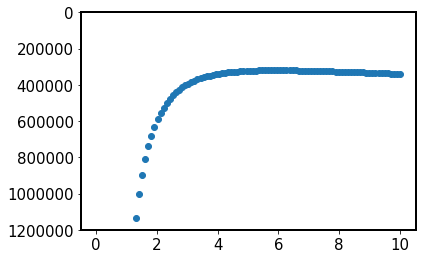

In [152]:
# print a marginalized version ...
plt.ylim(12e5)
plt.scatter(sigma_grid, np.sum(x, axis=0))

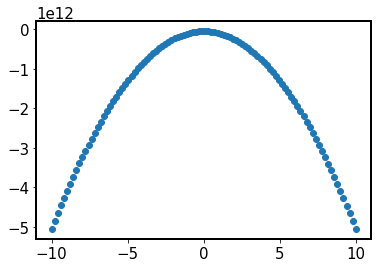

In [153]:
plt.scatter(mu_grid, -np.sum(x, axis=1))

### Plot logL flat prior residuals <a id='flat_residuals'></a>

[Jump to top](#toc)

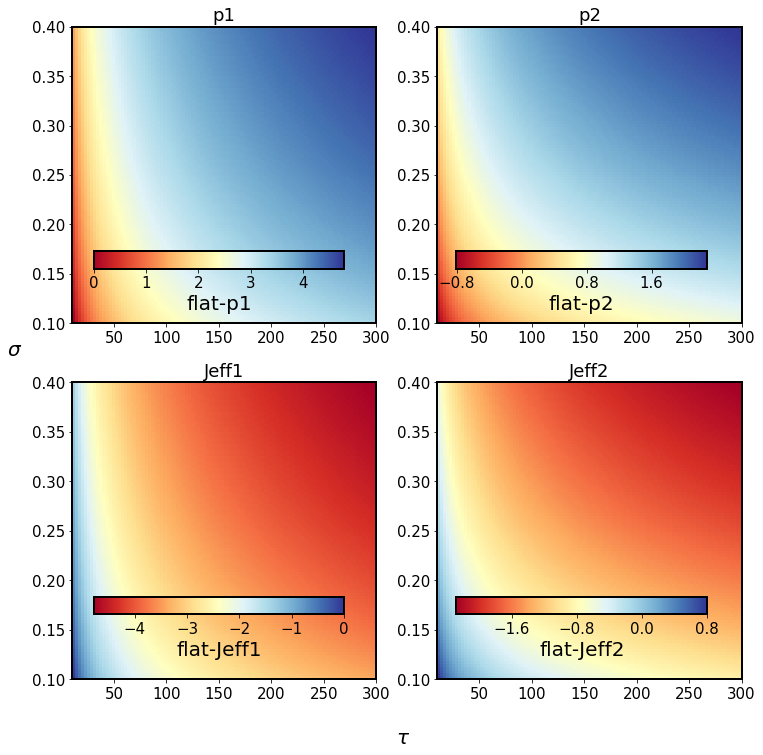

In [94]:
# Plot the residuals of posterior pdf based on flat prior - the other prior... 

from matplotlib import ticker
fig,axs = plt.subplots(2,2, figsize=(12,12))
ax = np.ravel(axs)
i =0 
cax_position = [[0.15,0.6,0.29,0.02],[0.57,0.6,0.29,0.02],
                [0.15,0.2,0.29,0.02],[0.57,0.2,0.29,0.02]
               ]
for prior in ['p1', 'p2', 'Jeff1', 'Jeff2']:
    z = loglike_dic['flat']-loglike_dic[prior]
    im = ax[i].imshow(z, extent=(tau_grid[0], tau_grid[-1],sigma_grid[0], sigma_grid[-1]),
                  cmap=plt.cm.get_cmap('RdYlBu'), 
                   aspect='auto', origin='lower')
    ax[i].set_title(prior)
    cax = fig.add_axes(cax_position[i])
    cbar = plt.colorbar(im,cax, orientation='horizontal', 
                    label='flat-'+prior)

    tick_locator = ticker.MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.update_ticks()
    i += 1

fig.text(0.5,0.05, r'$\tau$', fontsize=20)
fig.text(0.05,0.5, r'$\sigma$',fontsize=20)
plt.savefig(outDir+'posterior_flat-residuals.png', bbox_inches='tight')

### Plot log-likelihood in 4 different views <a id='logL_views'></a>

[Jump to top](#toc)

In [87]:
# For the entire grid,  make alternative maps of NxN  (z-dimension),
# reflecting tau, sigma,  sigma_hat, 
# so that each point on the grid has a value 
# of sigma, tau, sigma_hat,  as well as logL 
z_loglike = loglike
z_tau = np.zeros([N,N] , dtype=float)
z_sigma = np.zeros([N,N], dtype=float)
z_sigma_hat = np.zeros([N,N], dtype=float)
z_K = np.zeros([N,N], dtype=float)
for i in range(len(sigma_grid)):
    for j in range(len(tau_grid)):
        z_tau[i,j] = tau_grid[j]
        z_sigma[i,j] = sigma_grid[i]
        z_sigma_hat[i,j] = sigma_grid[i] * np.sqrt(2 / tau_grid[j])
        z_K[i,j] = tau_grid[j] * np.sqrt(sigma_grid[i]) * np.power(2, 0.25)

'/Users/chris/GradResearch/DRW_Celerite/data_products/Fig_Celerite_simulated_LC/2017-11-08/'

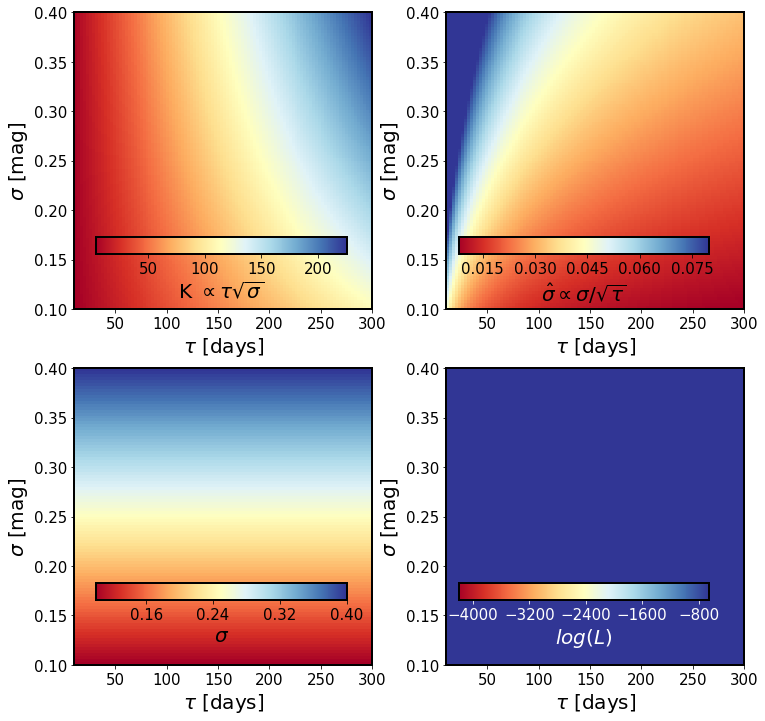

In [12]:
# Plot to show that it worked  : 
# Proof of concept 

fig,ax = plt.subplots(2,2,figsize=(12,12)) #, sharex=True, sharey=True
         
z = z_K
im = ax[0,0].imshow(z, extent=(tau_grid[0], tau_grid[-1],sigma_grid[0], sigma_grid[-1]),
              cmap=plt.cm.get_cmap('RdYlBu'),
               aspect='auto', origin='lower')
cax = fig.add_axes([0.15,0.6,0.29,0.02])
cbar = plt.colorbar(im,cax, orientation='horizontal', label='K '+r'$\propto \tau \sqrt{\sigma}$')
from matplotlib import ticker
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()

for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel(r'$\tau$ [days]')
        ax[i,j].set_ylabel(r'$\sigma$ [mag]')
        
z = z_sigma_hat
im = ax[0,1].imshow(z, extent=(tau_grid[0], tau_grid[-1],sigma_grid[0], sigma_grid[-1]),
              cmap=plt.cm.get_cmap('RdYlBu'), vmax=0.08,
               aspect='auto', origin='lower')
cax = fig.add_axes([0.57,0.6,0.29,0.02])
cbar = plt.colorbar(im,cax, orientation='horizontal', label=r'$\hat{\sigma} \propto \sigma / \sqrt{\tau}$')
from matplotlib import ticker
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()



z = z_sigma
im = ax[1,0].imshow(z, extent=(tau_grid[0], tau_grid[-1],sigma_grid[0], sigma_grid[-1]),
              cmap=plt.cm.get_cmap('RdYlBu'),
               aspect='auto', origin='lower')
cax = fig.add_axes([0.15,0.2,0.29,0.02])
cbar = plt.colorbar(im,cax, orientation='horizontal', label=r'$\sigma$')
from matplotlib import ticker
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()



z = z_loglike
im = ax[1,1].imshow(z, extent=(tau_grid[0], tau_grid[-1],sigma_grid[0], sigma_grid[-1]),
              cmap=plt.cm.get_cmap('RdYlBu'), vmax=-4200,
               aspect='auto', origin='lower')
cax = fig.add_axes([0.57,0.2,0.29,0.02])
cbar = plt.colorbar(im,cax, orientation='horizontal')
cbar.set_label(label=r'$log(L)$', color='white')

from matplotlib import ticker
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.ax.tick_params(colors='white')

fig.subplots_adjust(wspace=0.25)
# makes sense
plt.savefig(outDir+'sim_lc_logL_four_panels.png', bbox_inches='tight')

### Aside: fitting a  Gaussian noise with Celerite ...  <a id='gaussian_noise'></a>



[jump to top](#toc)

In [ ]:

# Simulate points drawn from a normal distribution...

y = np.random.normal(loc=0, scale = 1, size=1000)
plt.hist(y)
plt.scatter(np.arange(len(y)))

kernel = terms.RealTerm(log_a=np.log(np.var(y)), log_c=-np.log(10.0))
gp = celerite.GP(kernel, mean=np.mean(y), fit_mean=True)
gp.compute(x, yerr=0.001)
print("Initial log-likelihood: {0}".format(gp.log_likelihood(y)))

# Define a cost function
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

# Fit for the maximum likelihood parameters
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
soln = minimize(neg_log_like, initial_params,
                method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(soln.x)
print("Final log-likelihood: {0}".format(-soln.fun))

# Make the maximum likelihood prediction
t = np.linspace(0, 1000, 1000)
mu, var = gp.predict(y, t, return_var=True)
std = np.sqrt(var)

# Plot the data
color = "#ff7f0e"
plt.errorbar(x, y, yerr=0.01, fmt=".k", capsize=0)

plt.plot(t, mu, color=color)
plt.fill_between(t, mu+std, mu-std, color=color, alpha=0.3, edgecolor="none")
plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
#plt.xlim(-5, 5)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.title("maximum likelihood prediction");

This makes sense, because we would expect that K is the combination of tau, sigma, just like sigma_hat,  and log-likelihood looks just fine as well.... 

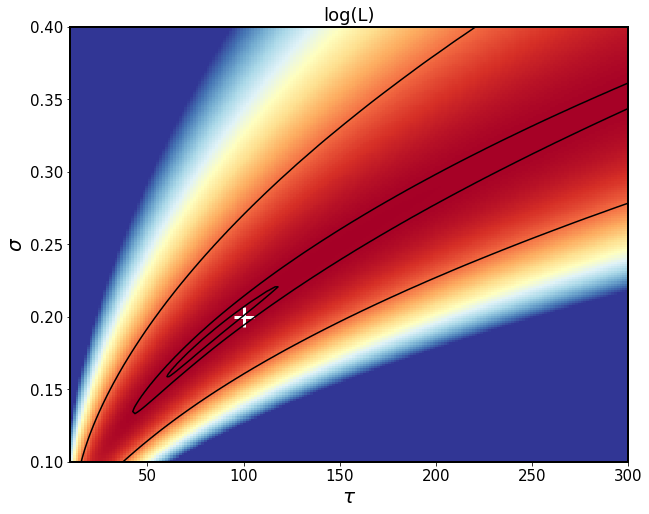

In [61]:
# Plot the loglikelihood and the contours...
# Using imshow 

fig,ax = plt.subplots(figsize=(10,8)) 

z = loglike /4000  # need to scale , otherwise we get too small numbers ... 

im = ax.imshow(z, extent=(tau_grid[0], tau_grid[-1],sigma_grid[0], sigma_grid[-1]),
              cmap=plt.cm.get_cmap('RdYlBu'), vmax = -0.9,
               aspect='auto', origin='lower')

ax.contour(tau_grid, sigma_grid, convert_to_stdev(z),
           levels=(0.683, 0.955, 0.997), colors='k')
ax.scatter(tau_in, sigma_in, marker='+', s=400, lw=3, c='white')

ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$\sigma$')
ax.set_title('log(L)')
plt.savefig(outDir + 'sim_lc_loglike.png', bbox_inches = 'tight')

In [50]:
sigma = np.exp(-loglike)
shape = sigma.shape
sigma = sigma.ravel()

# obtain the indices to sort and unsort the flattened array
i_sort = np.argsort(sigma)[::-1]
i_unsort = np.argsort(i_sort)

sigma_cumsum = sigma[i_sort].cumsum()
sigma_cumsum /= sigma_cumsum[-1]

sigma_cumsum[i_unsort].reshape(shape)

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

### Plotting the K-$\hat{\sigma}$ surface ... <a id='sigmahat_K'></a>

[Jump to top](#toc)

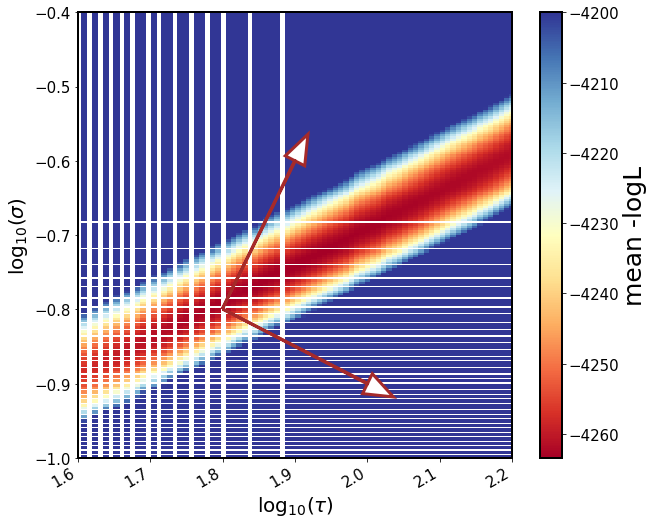

In [104]:
# Now, given that for each pixel I have a value of loglike,  tau,  sigma, sigma_hat, 
# I can also plot sigma_hat vs log(tau)  and color by loglike .. 
# plot 1 :  t1 vs t2 colored by  count 
from scipy.stats import binned_statistic_2d

x = np.log10(z_tau.flatten())
y = np.log10(z_sigma.flatten())
z = loglike.flatten()
nbins = 200
stats = binned_statistic_2d(x, y, values = z, statistic='mean', bins=nbins)

z_vals, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_vals[np.isnan(z_vals)] =0
z_reduce  =  z_vals # [:-1, :-1] no need to reduce here because x_edges are already given with the right size
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display...
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros...

# Plot 2D histogram using pcolor
fig,ax = plt.subplots(1,1, figsize=(8.5,7))
cm = plt.cm.get_cmap('RdYlBu')
image = ax.pcolormesh(x_edges,y_edges,z_masked, cmap=cm, vmax=-4200)  # np.log10(z_masked) gives log counts
fig.autofmt_xdate()
plt.tight_layout()
colorbar = fig.colorbar(image, ax = ax,  orientation='vertical')
colorbar.set_label('mean -logL', fontsize=25)
ax.set_xlabel(r'$\log_{10}(\tau)$')
ax.set_ylabel(r'$\log_{10}(\sigma)$')


# Why this does not produce perpendicular arrows ? ? ? ? ?? ? ? ? ?? ?  
# After all,   a in the second line is exactly  -1/a of the first one...
a = 2 
x1 = 1.8
y1 = -0.8
b = y1 - a * x1

x2 = 1.9 ;  y2 = a * x2 + b  
dx = x2-x1
dy = y2-y1
ax.arrow( x1, y1, dx, dy, fc="white", ec="brown",
head_width=0.03, head_length=0.04 , lw=3)

a = -0.5
b = y1 - a * x1

x2 = 2.0 ; y2 = a * x2 + b
dx = x2-x1
dy = y2-y1
ax.arrow( x1, y1, dx, dy,  fc="white", ec="brown",
head_width=0.03, head_length=0.04 , lw=3)

x0 = 1.6
y0 = -1.0
dx = 0.6
dy = dx 
ax.set_xlim(x0, x0+dx)
ax.set_ylim(y0, y0+dy)
plt.savefig(outDir+'sim_lc_log-log_K_sigma_hat_arrows.png', bbox_inches='tight')

So in theory,  along the diagonal in log(sigma) = log(tau) space is sigma_hat,   and perpendicular to that : K . 



But the problem is that if the scales (yrange, xrange) are not identical, then what is supposedly perpendicular, stops appearing to be so. 


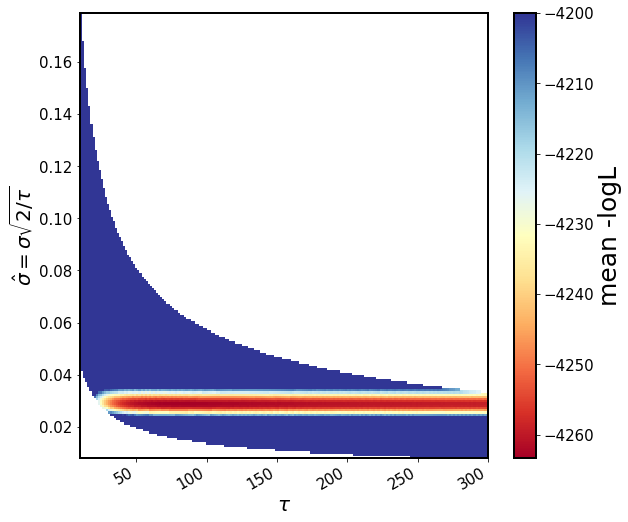

In [108]:
# Now, given that for each pixel I have a value of loglike,  tau,  sigma, sigma_hat, 
# I can also plot sigma_hat vs log(tau)  and color by loglike .. 
# plot 1 :  t1 vs t2 colored by  count 
from scipy.stats import binned_statistic_2d

x = z_tau.flatten()
y = z_sigma_hat.flatten()
z = loglike.flatten()
nbins = 200
stats = binned_statistic_2d(x, y, values = z, statistic='mean', bins=nbins)

z_vals, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_vals[np.isnan(z_vals)] =0
z_reduce  =  z_vals # [:-1, :-1] no need to reduce here because x_edges are already given with the right size
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display...
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros...

# Plot 2D histogram using pcolor
fig,ax = plt.subplots(1,1, figsize=(8,7))
cm = plt.cm.get_cmap('RdYlBu')
image = ax.pcolormesh(x_edges,y_edges,z_masked, cmap=cm, vmax=-4200)  # np.log10(z_masked) gives log counts
fig.autofmt_xdate()
plt.tight_layout()
colorbar = fig.colorbar(image, ax = ax,  orientation='vertical')
colorbar.set_label('mean -logL', fontsize=25)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$\hat{\sigma} = \sigma \sqrt{2 / \tau}$')

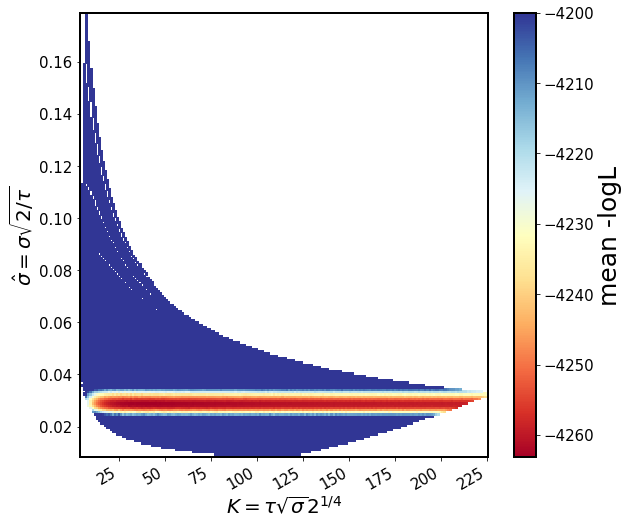

In [110]:
# Plot in space of sigma_hat  vs K  : 

# Now, given that for each pixel I have a value of loglike,  tau,  sigma, sigma_hat, 
# I can also plot sigma_hat vs log(tau)  and color by loglike .. 
# plot 1 :  t1 vs t2 colored by  count 
from scipy.stats import binned_statistic_2d

x = z_K.flatten()
y = z_sigma_hat.flatten()
z = loglike.flatten()
nbins = 200
stats = binned_statistic_2d(x, y, values = z, statistic='mean', bins=nbins)

z_vals, x_edges, y_edges = stats[0], stats[1], stats[2]
# replace all nan's by 0 ...
z_vals[np.isnan(z_vals)] =0
z_reduce  =  z_vals # [:-1, :-1] no need to reduce here because x_edges are already given with the right size
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display...
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)  # mask out zeros...

# Plot 2D histogram using pcolor
fig,ax = plt.subplots(1,1, figsize=(8,7))
cm = plt.cm.get_cmap('RdYlBu')
image = ax.pcolormesh(x_edges,y_edges,z_masked, cmap=cm, vmax=-4200)  # np.log10(z_masked) gives log counts
fig.autofmt_xdate()
plt.tight_layout()
colorbar = fig.colorbar(image, ax = ax,  orientation='vertical')
colorbar.set_label('mean -logL', fontsize=25)
ax.set_ylabel(r'$\hat{\sigma} = \sigma \sqrt{2 / \tau}$')
ax.set_xlabel(r'$K = \tau \sqrt{\sigma} 2^{1/4}$')

Now this doesn't make sense, because I would expect K to be very well constrained and sigma_hat very poorly, whereas it is the other way round here ... 

array([[-307.45711654, -322.68947841, -335.37899517, ...,  138.13419937,
         141.1105474 ,  144.08318288],
       [-308.74976309, -323.80473204, -336.37317102, ...,  119.97631851,
         122.88775481,  125.79565809],
       [-309.86236767, -324.74829228, -337.2016207 , ...,  102.48144101,
         105.32969254,  108.17458525],
       ..., 
       [ -81.75201012,  -91.84584407, -101.22450773, ..., -393.09589443,
        -393.33982478, -393.58068142],
       [ -80.71550307,  -90.80730019, -100.18487729, ..., -392.67889402,
        -392.92590132, -393.16983231],
       [ -79.6821688 ,  -89.77195448,  -99.14845969, ..., -392.25870843,
        -392.50876217, -392.75573702]])

In [300]:
bounds

[(None, None), (None, None)]

In [301]:
initial_params

array([-3.21887582, -4.60517019])

In [303]:
gp.get_parameter_names()

('kernel:log_a', 'kernel:log_c')

In [304]:
np.log(1/1)

0.0

In [305]:
np.log(1/1000)

-6.9077552789821368

In [309]:
2 * np.log(0.1)

-4.6051701859880909

In [310]:
bounds = [(-4.60517,  -2.40794  ), (- 6.9077, 0 )]

In [312]:
gp.get_parameter_bounds()

[(None, None), (None, None)]

In [313]:
gp.set_parameter?

In [322]:
gp.get_parameter_dict()

OrderedDict([('kernel:log_a', -1.83258146374831),
             ('kernel:log_c', -5.7037824746562009)])

In [324]:
gp.get_parameter_names()

('kernel:log_a', 'kernel:log_c')